In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but y

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

print("TensorFlow version:", tf.__version__)
print("MediaPipe version:", mp.__version__)

Mounted at /content/drive
TensorFlow version: 2.18.0
MediaPipe version: 0.10.21


In [3]:
# --- KONFIGURASI ---
# Pilih metode yang akan dilatih: 'SIBI' atau 'BISINDO'
METODE = 'SIBI'

if METODE == 'SIBI':
    DATA_DIR = '/content/drive/MyDrive/Skripsi/dataset/SIBI_augmentend'
    # Meskipun SIBI 1 tangan, model dilatih dengan input 126 agar konsisten
    NUM_LANDMARKS = 42 * 3
    MAX_HANDS = 1
    OUTPUT_MODEL_NAME = 'sibi_hybrid_model'
else:
    DATA_DIR = '/content/drive/MyDrive/dataset/BISINDO'
    NUM_LANDMARKS = 42 * 3 # 126 (untuk 2 tangan)
    MAX_HANDS = 2
    OUTPUT_MODEL_NAME = 'bisindo_hybrid_model'

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 200 # Epoch untuk training awal
FINE_TUNE_EPOCHS = 100 # Epoch untuk fine-tuning

# --- INISIALISASI MEDIAPIPE ---
mp_hands = mp.solutions.hands
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=MAX_HANDS, min_detection_confidence=0.5)

# --- FUNGSI GENERATOR DATA (dengan On-the-fly Mirroring) ---
CLASS_NAMES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(CLASS_NAMES)
class_to_int = {label: i for i, label in enumerate(CLASS_NAMES)}

def data_generator():
    for label_name in CLASS_NAMES:
        label_dir = os.path.join(DATA_DIR, label_name)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)

            cv_image = cv2.imread(image_path)
            if cv_image is None: continue

            # --- DATA ASLI ---
            image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            results = hands_model.process(image_rgb)
            landmarks_vector_original = np.zeros(NUM_LANDMARKS, dtype=np.float32)
            if results.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                    handedness = results.multi_handedness[i].classification[0].label
                    coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                    relative_coords = (coords - coords[0]).flatten()
                    if handedness == 'Right': landmarks_vector_original[0:63] = relative_coords
                    elif handedness == 'Left': landmarks_vector_original[63:126] = relative_coords
            image_original_tf = tf.convert_to_tensor(image_rgb)
            image_original_tf = tf.image.resize(image_original_tf, IMAGE_SIZE)
            yield {'image_input': image_original_tf, 'landmark_input': landmarks_vector_original}, class_to_int[label_name]

            # --- DATA CERMIN (AUGMENTASI ON-THE-FLY) ---
            flipped_image = cv2.flip(cv_image, 1)
            flipped_image_rgb = cv2.cvtColor(flipped_image, cv2.COLOR_BGR2RGB)
            results_flipped = hands_model.process(flipped_image_rgb)
            landmarks_vector_flipped = np.zeros(NUM_LANDMARKS, dtype=np.float32)
            if results_flipped.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results_flipped.multi_hand_landmarks):
                    handedness = results_flipped.multi_handedness[i].classification[0].label
                    coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                    relative_coords = (coords - coords[0]).flatten()
                    if handedness == 'Right': landmarks_vector_flipped[63:126] = relative_coords
                    elif handedness == 'Left': landmarks_vector_flipped[0:63] = relative_coords
            image_flipped_tf = tf.convert_to_tensor(flipped_image_rgb)
            image_flipped_tf = tf.image.resize(image_flipped_tf, IMAGE_SIZE)
            yield {'image_input': image_flipped_tf, 'landmark_input': landmarks_vector_flipped}, class_to_int[label_name]

print(f"Generator siap untuk metode {METODE} dengan dukungan mirroring.")

Generator siap untuk metode SIBI dengan dukungan mirroring.


In [4]:
output_signature = (
    {'image_input': tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
     'landmark_input': tf.TensorSpec(shape=(NUM_LANDMARKS,), dtype=tf.float32)},
    tf.TensorSpec(shape=(), dtype=tf.int32)
)
dataset = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)

DATASET_SIZE = sum([len(files) for r, d, files in os.walk(DATA_DIR)]) * 2
train_size = int(0.8 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size=2048)
train_dataset = dataset.take(train_size).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
print("Pipeline data training dan validasi telah siap.")

Pipeline data training dan validasi telah siap.


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Cabang Visual (CNN)
input_image = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
augmented_image = data_augmentation(input_image)
rescaling = layers.Rescaling(1./255)(augmented_image)
base_model_cnn = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=rescaling)
base_model_cnn.trainable = False
visual_features = GlobalAveragePooling2D()(base_model_cnn.output)

# Cabang Landmark (MLP)
input_landmarks = Input(shape=(NUM_LANDMARKS,), name='landmark_input')
x = Dense(256, activation='relu')(input_landmarks)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
landmark_features = Dense(64, activation='relu')(x)

# Menggabungkan
combined_features = Concatenate()([visual_features, landmark_features])
x = Dropout(0.5)(combined_features)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=[input_image, input_landmarks], outputs=output)

# Kompilasi
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,158,205 (15.86 MB)

 Trainable params: 108,634 (424.35 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Memulai training awal...
Epoch 1/200
    521/Unknown 918s 2s/step - accuracy: 0.4524 - loss: 1.6260

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


521/521 ━━━━━━━━━━━━━━━━━━━━ 1764s 3s/step - accuracy: 0.4527 - loss: 1.6257 - val_accuracy: 0.3377 - val_loss: 7.5355
Epoch 2/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.8139 - loss: 0.7321 - val_accuracy: 0.3377 - val_loss: 7.7012
Epoch 3/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8649 - loss: 0.5262 - val_accuracy: 0.3368 - val_loss: 8.0309
Epoch 4/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8919 - loss: 0.4274 - val_accuracy: 0.3797 - val_loss: 8.0824
Epoch 5/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9071 - loss: 0.3885 - val_accuracy: 0.3737 - val_loss: 8.8806
Epoch 6/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9066 - loss: 0.3820 - val_accuracy: 0.4196 - val_loss: 9.0010
Epoch 7/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.9185 - loss: 0.3263 - val_accuracy: 0.3716 - val_loss: 9.7607
Epoch 8/200
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9318 - loss: 0.2446 - val_

ValueError: x and y must have same first dimension, but have shapes (200,) and (301,)

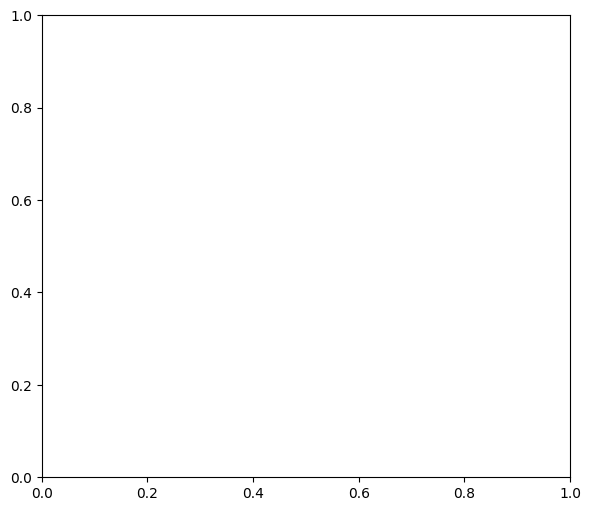

In [6]:
# Training Awal
print("Memulai training awal...")
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=1)

# Fine-Tuning
print("\nMemulai proses fine-tuning...")
base_model_cnn.trainable = True
for layer in base_model_cnn.layers[:150]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

total_epochs = EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset, verbose=1)


acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save(f'{OUTPUT_MODEL_NAME}_v_final.keras')
print(f"Model berhasil disimpan sebagai  '{OUTPUT_MODEL_NAME}_v_final.keras'")

In [6]:
# 1. Cairkan base model
base_model_cnn.trainable = True

# Kita hanya ingin melatih beberapa layer teratas, bukan semuanya.
# Mari kita bekukan layer-layer bawah dan hanya latih dari layer ke-150 ke atas.
fine_tune_at = 150
for layer in base_model_cnn.layers[:fine_tune_at]:
    layer.trainable = False

# 2. Kompilasi ulang model dengan learning rate yang sangat rendah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model siap untuk di-fine-tune.")
model.summary() # Perhatikan jumlah 'Trainable params' yang bertambah

Model siap untuk di-fine-tune.


Model: "Hybrid_Sign_Language_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,102,237 (15.65 MB)

 Trainable params: 3,341,714 (12.75 MB)

 Non-trainable params: 760,523 (2.90 MB)

Memulai proses fine-tuning...
Epoch 200/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.6114 - loss: 3.8533 - val_accuracy: 0.3596 - val_loss: 75.4767
Epoch 201/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.8641 - loss: 0.4881 - val_accuracy: 0.5636 - val_loss: 72.2034
Epoch 202/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9394 - loss: 0.2212 - val_accuracy: 0.5713 - val_loss: 71.1744
Epoch 203/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9556 - loss: 0.1430 - val_accuracy: 0.5718 - val_loss: 70.7927
Epoch 204/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9611 - loss: 0.1318 - val_accuracy: 0.5713 - val_loss: 70.4945
Epoch 205/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9700 - loss: 0.1049 - val_accuracy: 0.5718 - val_loss: 70.4943
Epoch 206/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9710 - loss: 0.1007 - val_accuracy: 0.5723 - val_loss: 70.4141
Epoch 207/300
261/261 ━━━━━━━━━

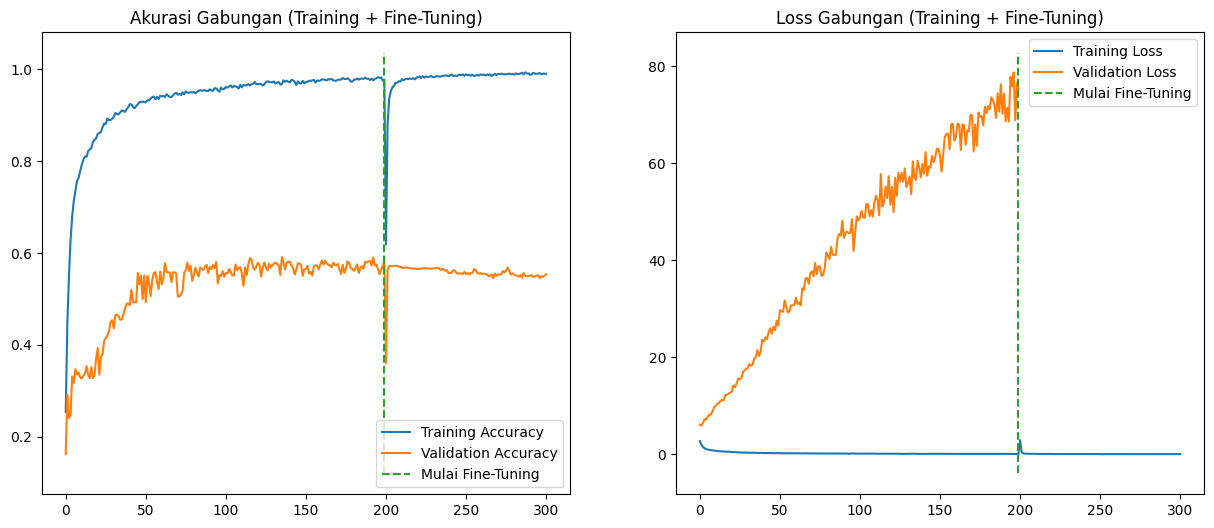

In [7]:
fine_tune_epochs = 100 # Latih untuk 10 epoch tambahan
total_epochs = EPOCHS + fine_tune_epochs

print("Memulai proses fine-tuning...")
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Melanjutkan dari epoch terakhir
    validation_data=validation_dataset,
    verbose=1
)

# Gabungkan history dari training awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Akurasi Gabungan (Training + Fine-Tuning)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Loss Gabungan (Training + Fine-Tuning)')
plt.show()

In [ ]:
model.save('sibi_hybrid_model_v4_finetuned.keras')
print("Model hasil fine-tuning berhasil disimpan sebagai 'sibi_hybrid_model_v4_finetuned.keras'")

Model hasil fine-tuning berhasil disimpan sebagai 'sibi_hybrid_model_v2_finetuned.keras'
